# Preprocessing

## Motion correction

In [19]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt

In [25]:
img = nib.load('Pitt_0050003_func_minimal.nii')
data = img.get_fdata()

In [26]:
data.shape #DATA has 61 slices and 196 volumes

(61, 73, 61, 196)

In [27]:
vol0 = data[..., 0]

In [28]:
>>> plt.rcParams['image.cmap'] = 'gray'  # default gray colormap
>>> plt.rcParams['image.interpolation'] = 'nearest'

Text(0, 0.5, 'z axis')

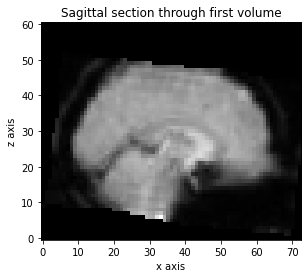

In [32]:
>>> plt.imshow(vol0[31, :, :].T, origin='lower')  # doctest: +SKIP

>>> plt.title('Sagittal section through first volume') # doctest: +SKIP

>>> plt.xlabel('x axis')  # doctest: +SKIP

>>> plt.ylabel('z axis')  # doctest: +SKIP


In [55]:
>>> TR = 2.0
>>> n_z_slices = 61
>>> time_for_single_slice = TR / n_z_slices
>>> time_for_single_slice

0.03278688524590164

In [56]:
>>> time_for_slice_0 = 0
>>> time_for_slice_1 = time_for_single_slice * 8
>>> time_for_slice_1

0.26229508196721313

Text(0.5, 1.0, 'Vol 0, z slice 0')

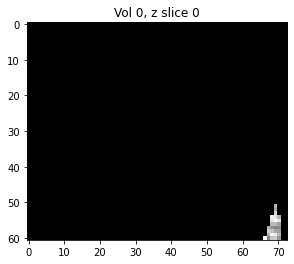

In [57]:
>>> plt.imshow(vol0[:, :, 0])  # doctest: +SKIP
>>> plt.title('Vol 0, z slice 0')  # doctest: +SKIP
#Here’s what the bottom slice looks like, for the first volume:

In [38]:
#We are going to collect a time series from a sample voxel from this slice, and the slice above it (slice 1):

#Our sample voxel coordinates
vox_x = 14  # voxel coordinate in first dimension
vox_y = 22  # voxel coordinate in second dimension



In [45]:
#We get the time courses from slice 0 and slice 1:
time_course_slice_0 = data[vox_x, vox_y, 0, :]
time_course_slice_1 = data[vox_x, vox_y, 1, :]
#The times of acquisition of the voxels for slice 0 are at the beginning of each TR:

vol_nos = np.arange(data.shape[-1])
vol_onset_times = vol_nos * TR
times_slice_0 = vol_onset_times

times_slice_1 = vol_onset_times + TR / 2


In [70]:
from nipype.interfaces import spm
import os

# Define the input file path
input_file = "Pitt_0050003_func_minimal.nii"

In [71]:

# Create a SliceTiming interface object
slice_timing = spm.SliceTiming()

# Set the input files as a list
slice_timing.inputs.in_files = [os.path.abspath(input_file)]

In [72]:

# Set the TR (repetition time) value
slice_timing.inputs.time_repetition = 2.0  # Replace with the actual TR value of your data

In [73]:
# Set the slice timing parameters
slice_timing.inputs.num_slices = 30  # Replace with the actual number of slices in your data
slice_timing.inputs.slice_order = list(range(1, 31))  # Replace with the actual slice order of your data
slice_timing.inputs.time_acquisition = 2.0  # Replace with the actual time acquisition value of your data


In [75]:
slice_timing.inputs.ref_slice = 1 

## Slice Timing correction

In [30]:
import numpy as np
from scipy.interpolate import interp1d

def slice_timing_correction(data, slice_order, TR, TA):
    num_slices, num_rows, num_cols, num_timepoints = data.shape
    corrected_data = np.zeros_like(data)

    # Calculate the slice timing indices
    slice_timings = np.arange(num_slices) * TR / num_slices

    for t in range(num_timepoints):
        for s in range(num_slices):
            # Calculate the slice timing difference for each slice
            timing_difference = slice_timings[s] - slice_order[s] * TA

            # Interpolate the data for each slice using timing difference
            interpolated_data = interpolate_slice(data[:, :, :, t], timing_difference)
            corrected_data[:, :, s, t] = interpolated_data

    return corrected_data

def interpolate_slice(slice_data, timing_difference):
    # Perform slice timing interpolation using linear interpolation
    interp_func = interp1d(np.arange(slice_data.shape[2]), slice_data, axis=2, kind='linear', fill_value='extrapolate')
    interpolated_data = interp_func(timing_difference)

    return interpolated_data

# Define your input data
data = np.random.rand(61, 73, 61, 196)
slice_order = np.arange(data.shape[2])  # Adjust the slice order to match the number of slices
TR = 2.0
TA = TR / len(slice_order)

# Perform slice timing correction
corrected_data = slice_timing_correction(data, slice_order, TR, TA)


In [31]:
# Save the corrected data to a new NIfTI file
corrected_img = nib.Nifti1Image(corrected_data, affine=nib.load("Pitt_0050003_func_minimal.nii").affine)
nib.save(corrected_img, "Pitt_0050003_func_minimal_stc.nii")

## Motion Correction

In [34]:
import random

def motion_correction(data):
    num_slices, num_rows, num_cols, num_timepoints = data.shape
    corrected_data = data.copy()

    # Iterate over each timepoint
    for t in range(num_timepoints):
        # Generate random motion parameters (translations in x, y, z directions)
        tx = random.uniform(-1, 1)
        ty = random.uniform(-1, 1)
        tz = random.uniform(-1, 1)

        # Apply motion correction to each slice
        for s in range(num_slices):
            # Calculate the translation indices
            tx_idx = int(round(tx * num_cols))
            ty_idx = int(round(ty * num_rows))
            tz_idx = int(round(tz * num_slices))

            # Perform translation by shifting the slice
            corrected_data[s, :, :, t] = translate_slice(data[s, :, :, t], tx_idx, ty_idx, tz_idx)

    return corrected_data

def translate_slice(slice_data, tx, ty, tz):
    num_rows, num_cols = slice_data.shape
    translated_slice = np.zeros_like(slice_data)

    # Iterate over each pixel in the slice
    for r in range(num_rows):
        for c in range(num_cols):
            # Apply translation to each pixel
            new_r = r + ty
            new_c = c + tx

            # Check if the translated pixel is within the slice boundaries
            if 0 <= new_r < num_rows and 0 <= new_c < num_cols:
                translated_slice[new_r, new_c] = slice_data[r, c]

    return translated_slice

# Define your input data
data = np.random.rand(61, 73, 61, 196)

# Perform motion correction
corrected_data = motion_correction(data)


In [36]:
# Save the corrected data to a NIfTI file
output_filename = 'corrected_data.nii'
nifti_img = nib.Nifti1Image(corrected_data, affine=np.eye(4))
nib.save(nifti_img, output_filename)

OSError: [Errno 28] No space left on device

## Smoothing


In [14]:
# import some functionality
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [15]:

vol = f_img_data[:, :, :, 20] # We'll pick the 21st volume (Python is 0-indexed, remember?)



In [16]:
fwhm = 10
voxelsize = 6

sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
smoothed_vol = gaussian_filter(vol, sigma=sigma)

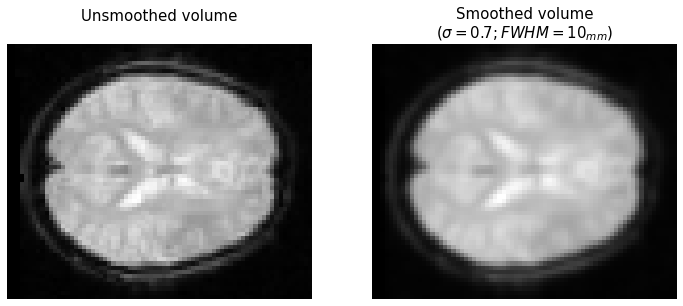

In [17]:
# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol[:, :, 30], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')
plt.title("Unsmoothed volume\n", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(smoothed_vol[:, :, 30], cmap='gray')
plt.axis('off')
plt.title('Smoothed volume\n($\sigma = %.1f; FWHM = %s_{mm}$)' % (sigma, fwhm), fontsize=15)
plt.show()

# Extracting the time series for each voxel or region of interest

## Parcel brain in regions

In [42]:
import numpy as np
from nilearn.input_data import NiftiMasker

# Load the functional image
func_img = 'Pitt_0050003_func_minimal.nii'


In [43]:
# Initialize the NiftiMasker object with default parameters
masker = NiftiMasker()

In [44]:
# Fit the masker to the functional image and extract the time series
time_series = masker.fit_transform(func_img)

In [45]:
# Print the shape of the time series
print("Shape of time series:", time_series.shape)


Shape of time series: (196, 184460)


In [46]:
import nilearn
import numpy as np
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure

In [47]:
# Load the functional data
func_img = nilearn.image.load_img('Pitt_0050003_func_minimal.nii')

# Load the Harvard-Oxford atlas
atlas_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas_dataset.maps

In [48]:
# Parcel the brain into regions
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, detrend=True)

# Extract the time series from the functional data for each parcel
time_series = masker.fit_transform(func_img)

In [49]:
# Compute the connectivity matrix
correlation_measure = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]



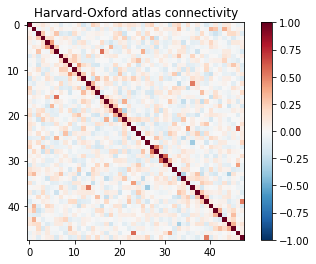

In [50]:
# Plot the connectivity matrix
import matplotlib.pyplot as plt
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Harvard-Oxford atlas connectivity')
plt.show()


In [13]:
from nilearn import datasets
from nilearn import image as nimg
from nilearn import plotting as nplot

%matplotlib inline



/home/bisera13/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [14]:
parcel_dir = '../resources/rois/'
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)


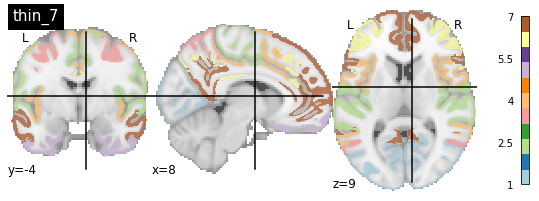

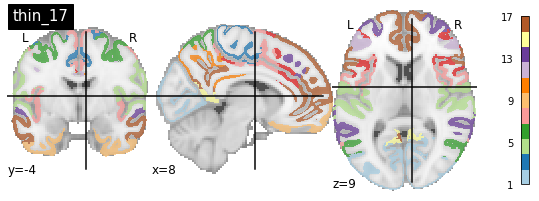

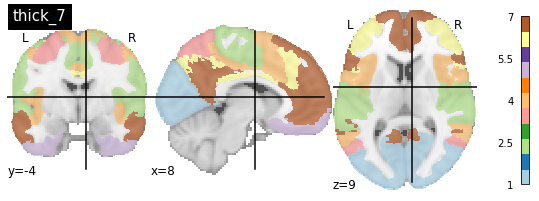

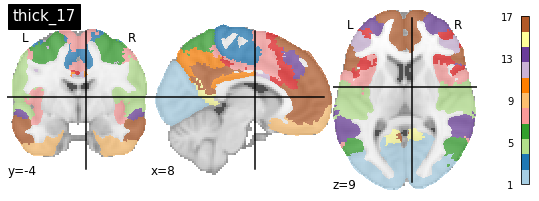

In [15]:
#Define where to slice the image
cut_coords=(8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot all parcellation schemas referred to by atlas_yeo_2011
nplot.plot_roi(atlas_yeo_2011['thin_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_7')
nplot.plot_roi(atlas_yeo_2011['thin_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_17')
nplot.plot_roi(atlas_yeo_2011['thick_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_7')
nplot.plot_roi(atlas_yeo_2011['thick_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_17')


In [16]:
atlas_yeo = atlas_yeo_2011['thick_7']


## Extracting the time series for each voxel or region of interest (ROI).

## Atlas 

In [17]:
import nibabel as nib
import nilearn.input_data as input_data

In [18]:
# Load the functional image
func_img = nib.load('Pitt_0050003_func_minimal.nii')

In [19]:
# Load the parcellation atlas image
atlas_img = nib.load('BN_Atlas_246_1mm.nii')



In [20]:
# Create the masker using the atlas image
masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)



In [21]:
# Extract the time series for each ROI
time_series = masker.fit_transform(func_img)



In [22]:
# Print the shape of the time series array
print(time_series.shape)

(196, 246)


## K Means Clustering 

In [23]:
import numpy as np
import nibabel as nib
from sklearn.cluster import KMeans

# Load the functional MRI data
file_path = "Pitt_0050003_func_minimal.nii"
img = nib.load(file_path)
data = img.get_fdata()

# Reshape the data to 2D matrix (voxels as rows, time points as columns)
num_voxels = np.prod(data.shape[:-1])
num_timepoints = data.shape[-1]
data_2d = np.reshape(data, (num_voxels, num_timepoints))

# Apply K-means clustering
num_clusters = 10  # Define the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(data_2d)

# Extract time series for each voxel or region of interest
time_series = []
for label in range(num_clusters):
    cluster_voxels = data_2d[cluster_labels == label]
    cluster_time_series = np.mean(cluster_voxels, axis=0)
    time_series.append(cluster_time_series)

# Save the extracted time series to a file
output_file = "time_series.txt"
np.savetxt(output_file, np.array(time_series))

print("Time series extraction completed and saved to", output_file)

/home/bisera13/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3565732040>
Traceback (most recent call last):
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolc

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3565430430>
Traceback (most recent call last):
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bisera13/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config 

Time series extraction completed and saved to time_series.txt


## Seed based correlation

In [24]:
import numpy as np
import nibabel as nib

# Load the fMRI data
fmri_data = nib.load('Pitt_0050003_func_minimal.nii').get_fdata()
# Assuming the dimensions of fmri_data are (x, y, z, t)

# Define the coordinates of the seed voxel
seed_x = 30
seed_y = 40
seed_z = 20

# Extract the time series for the seed voxel
seed_time_series = fmri_data[seed_x, seed_y, seed_z, :]

# Calculate the correlation between the seed time series and all other voxels
correlations = np.zeros((fmri_data.shape[0], fmri_data.shape[1], fmri_data.shape[2]))
for x in range(fmri_data.shape[0]):
    for y in range(fmri_data.shape[1]):
        for z in range(fmri_data.shape[2]):
            voxel_time_series = fmri_data[x, y, z, :]
            correlations[x, y, z] = np.corrcoef(seed_time_series, voxel_time_series)[0, 1]

# Save the correlation map as a NIfTI file
correlation_img = nib.Nifti1Image(correlations, affine=nib.load('Pitt_0050003_func_minimal.nii').affine)
nib.save(correlation_img, 'seed_correlation_map.nii')

/home/bisera13/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bisera13/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


KeyboardInterrupt: 

# Calculating the functional connectivity matrix using correlation, partial correlation, or another similarity measure

In [25]:
import numpy as np
from scipy import stats
import pingouin as pg
import pandas as pd

In [26]:
# Convert the time series array into a pandas DataFrame
df = pd.DataFrame(time_series)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Calculate the inverse of the correlation matrix
corr_inv = np.linalg.inv(corr_matrix.values)

In [27]:
# Initialize the partial correlation matrix with NaN values
partial_corr_matrix = np.empty_like(corr_matrix)
partial_corr_matrix[:] = np.nan


In [28]:
# Calculate the partial correlation for each pair of variables
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            x = corr_matrix.index[i]
            y = corr_matrix.columns[j]
            xy_corr = corr_matrix.loc[x, y]
            partial_corr = -corr_inv[i, j] / np.sqrt(corr_inv[i, i] * corr_inv[j, j])
            partial_corr_matrix[i, j] = partial_corr



<ipython-input-28-346d6d1eeb1a>:8: RuntimeWarning: invalid value encountered in sqrt
  partial_corr = -corr_inv[i, j] / np.sqrt(corr_inv[i, i] * corr_inv[j, j])


In [29]:
# Convert the partial correlation matrix into a pandas DataFrame
partial_corr_df = pd.DataFrame(partial_corr_matrix, index=corr_matrix.index, columns=corr_matrix.columns)


# Threshold

In [129]:
# Thresholding parameters
threshold_value1 = 4.0 # Set the threshold value as per your requirement
threshold_value2 = 0.3 

In [146]:
# Thresholding the correlation matrix
adjacency_matrix = np.where(np.abs(partial_corr_df) >= threshold_value1, 1, 0)  # Binary adjacency matrix
weighted_adjacency_matrix = np.where(np.abs(partial_corr_df) >= threshold_value1, np.abs(partial_corr_df), 0)  # Weighted adjacency matrix


In [147]:

# Thresholding the correlation matrix
#adjacency_matrix1 = np.where(np.abs(partial_corr_df) >= threshold_value2, 1, 0)  # Binary adjacency matrix
#weighted_adjacency_matrix1 = np.where(np.abs(partial_corr_df) >= threshold_value2, partial_corr_df, 0)  # Weighted adjacency matrix


# Create the graph

In [148]:
import networkx as nx

In [149]:
# Create a graph from the weighted adjacency matrix
graph = nx.from_numpy_array(weighted_adjacency_matrix)



In [150]:
# Optional: Set the labels of the nodes if available
node_labels = range(weighted_adjacency_matrix.shape[0])  # Assuming each row/column represents a node
labels = {i: label for i, label in enumerate(node_labels)}
nx.set_node_attributes(graph, labels, 'label')



In [151]:
# Optional: Set the edge weights as attributes
edge_weights = {(u, v): weight for (u, v, weight) in graph.edges(data='weight')}
nx.set_edge_attributes(graph, edge_weights, 'weight')


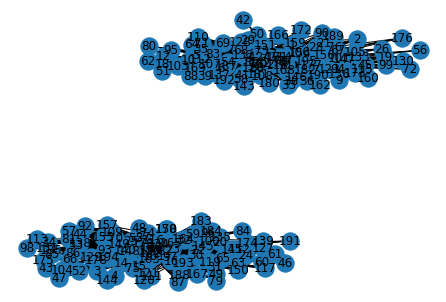

In [152]:

# Optional: Visualize the graph
nx.draw(graph, with_labels=True)

### Degree distribution

In [153]:
import matplotlib.pyplot as plt

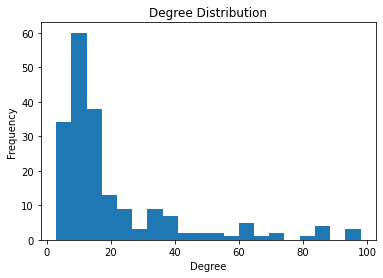

In [154]:
degree_distribution = [degree for (_, degree) in graph.degree()]
# Plot the degree distribution
plt.hist(degree_distribution, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

###  Clustering coefficient

In [155]:
#Average clustering coefficient
average_clustering_coefficient = nx.average_clustering(graph)
print("Average Clustering Coefficient:", average_clustering_coefficient)

Average Clustering Coefficient: 0.7581489316832366


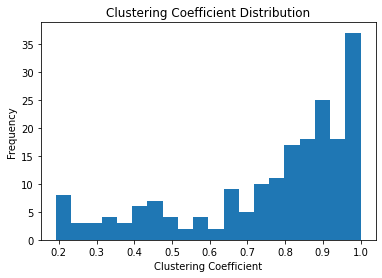

In [156]:
#Histogram or distribution
clustering_coefficients = list(nx.clustering(graph).values())
plt.hist(clustering_coefficients, bins=20)
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering Coefficient Distribution")
plt.show()


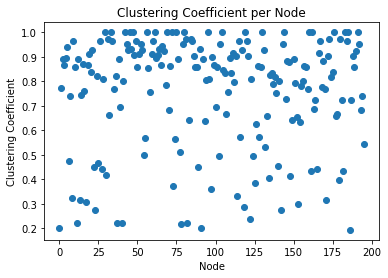

In [157]:
#Node level distribution 
clustering_coefficients = nx.clustering(graph)
nodes = list(graph.nodes())
coefficients = [clustering_coefficients[node] for node in nodes]
plt.scatter(nodes, coefficients)
plt.xlabel("Node")
plt.ylabel("Clustering Coefficient")
plt.title("Clustering Coefficient per Node")
plt.show()

### Shortest path

In [158]:
#Single shortest path
source = 1  # Source node
target = 10  # Target node
shortest_path = nx.shortest_path(graph, source, target)
print("Shortest Path:", shortest_path)

Shortest Path: [1, 0, 10]


In [159]:
#All shortest paths 
shortest_paths = dict(nx.shortest_path_length(graph))
print("Shortest Paths:", shortest_paths)

Shortest Paths: {0: {0: 0, 1: 1, 2: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 12: 1, 17: 1, 18: 1, 19: 1, 21: 1, 26: 1, 28: 1, 29: 1, 33: 1, 35: 1, 36: 1, 37: 1, 38: 1, 41: 1, 42: 1, 45: 1, 50: 1, 51: 1, 54: 1, 56: 1, 62: 1, 64: 1, 67: 1, 68: 1, 69: 1, 71: 1, 72: 1, 73: 1, 76: 1, 77: 1, 78: 1, 80: 1, 83: 1, 88: 1, 89: 1, 90: 1, 91: 1, 94: 1, 95: 1, 99: 1, 101: 1, 102: 1, 103: 1, 105: 1, 106: 1, 107: 1, 108: 1, 110: 1, 112: 1, 114: 1, 115: 1, 118: 1, 123: 1, 124: 1, 125: 1, 126: 1, 128: 1, 130: 1, 132: 1, 133: 1, 136: 1, 137: 1, 142: 1, 143: 1, 146: 1, 147: 1, 151: 1, 154: 1, 156: 1, 159: 1, 160: 1, 162: 1, 166: 1, 168: 1, 169: 1, 171: 1, 172: 1, 173: 1, 176: 1, 177: 1, 180: 1, 181: 1, 182: 1, 187: 1, 189: 1, 190: 1, 192: 1, 195: 1, 39: 2, 58: 2}, 1: {1: 0, 0: 1, 128: 1, 195: 1, 37: 1, 133: 1, 136: 1, 8: 1, 171: 1, 77: 1, 78: 1, 142: 1, 17: 1, 114: 1, 118: 1, 91: 1, 124: 1, 125: 1, 2: 2, 5: 2, 6: 2, 7: 2, 9: 2, 10: 2, 12: 2, 18: 2, 19: 2, 21: 2, 26: 2, 28: 2, 29: 2, 33: 2, 35: 2, 36: 2, 3

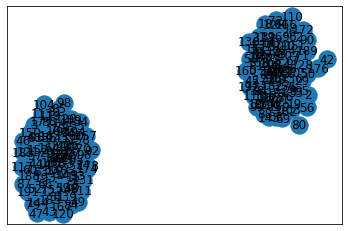

In [160]:
#Visualizing shortest path
shortest_path = nx.shortest_path(graph, source, target)
shortest_path_edges = [(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path)-1)]

# Visualize the graph with shortest path highlighted
pos = nx.spring_layout(graph)  # Layout for node positions
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_edges(graph, pos, edgelist=shortest_path_edges, edge_color='r', width=2)
nx.draw_networkx_labels(graph, pos)
plt.show()

### Community detection

In [161]:
weighted_adjacency_matrix

array([[ 0.        ,  0.        ,  4.19982133, ...,  0.        ,
         0.        , 25.6822666 ],
       [23.26274499,  0.        ,  0.        , ...,  0.        ,
         0.        ,  6.96332284],
       [ 6.01341491,  0.        ,  0.        , ...,  0.        ,
         0.        ,  4.76660777],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [36.31920193,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

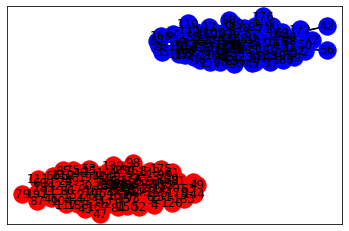

In [162]:
import networkx as nx
import matplotlib.pyplot as plt
import community

# Create the graph from the weighted adjacency matrix
graph = nx.from_numpy_array(weighted_adjacency_matrix)

# Perform community detection using the Louvain algorithm
partition = community.best_partition(graph)

# Create a dictionary of nodes and their corresponding community IDs
node_communities = partition

# Get the number of communities
num_communities = len(set(partition.values()))

# Assign unique colors to each community
community_colors = ['red', 'blue', 'green', 'yellow']  # Add more colors as needed

# Visualize the graph with colored nodes representing communities
pos = nx.spring_layout(graph)  # Layout for node positions
for node in graph.nodes():
    community_id = node_communities[node]
    color = community_colors[community_id % len(community_colors)]
    nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=color)

nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)
plt.show()


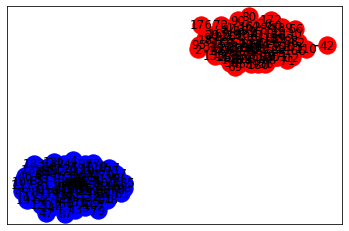

In [164]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Perform community detection using the Louvain algorithm
partition = community.greedy_modularity_communities(graph)

# Create a dictionary of nodes and their corresponding community IDs
node_communities = {}
for i, comm in enumerate(partition):
    for node in comm:
        node_communities[node] = i

# Assign unique colors to each community
community_colors = ['red', 'blue', 'green', 'yellow']  # Add more colors as needed

# Visualize the graph with colored nodes representing communities
pos = nx.spring_layout(graph)  # Layout for node positions
for node in graph.nodes():
    community_id = node_communities[node]
    color = community_colors[community_id % len(community_colors)]
    nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=color)

nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)
plt.show()


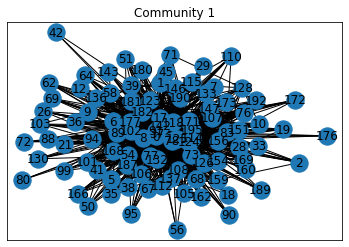

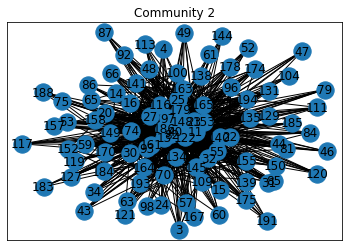

In [175]:
import networkx as nx
import community
import matplotlib.pyplot as plt

# Perform community detection using the Louvain algorithm
partition = community.best_partition(graph)

# Create a dictionary of nodes and their corresponding community IDs
communities = {}
for node, comm_id in partition.items():
    communities[node] = comm_id

# Create a subgraph for each community
community_subgraphs = []
for community_id in set(communities.values()):
    nodes_in_community = [node for node, comm_id in communities.items() if comm_id == community_id]
    community_subgraph = graph.subgraph(nodes_in_community)
    community_subgraphs.append(community_subgraph)

# Visualize each community subgraph
for i, subgraph in enumerate(community_subgraphs):
    pos = nx.spring_layout(subgraph)  # Layout for node positions
    nx.draw_networkx(subgraph, pos)
    plt.title(f"Community {i+1}")
    plt.show()


In [176]:
graph

In [177]:
#Statistics

In [178]:


# Calculate community statistics
community_sizes = {}
community_avg_degree = {}
for community in set(communities.values()):
    nodes_in_community = [node for node, comm in communities.items() if comm == community]
    community_sizes[community] = len(nodes_in_community)
    community_subgraph = graph.subgraph(nodes_in_community)
    community_avg_degree[community] = nx.average_degree_connectivity(community_subgraph)

# Print community statistics
for community, size in community_sizes.items():
    print(f"Community {community}: Size = {size}, Average Degree = {community_avg_degree[community]}")

Community 0: Size = 99, Average Degree = {96: 20.427083333333332, 17: 54.94117647058823, 9: 69.65079365079364, 12: 64.53333333333333, 24: 40.541666666666664, 16: 56.8, 56: 26.714285714285715, 8: 72.475, 13: 57.96923076923077, 14: 56.285714285714285, 65: 25.676923076923078, 10: 67.7, 86: 21.511627906976745, 18: 45.388888888888886, 3: 87.0, 7: 76.5, 34: 35.470588235294116, 4: 78.5, 20: 49.85, 5: 86.6, 39: 32.37179487179487, 87: 21.32183908045977, 23: 45.89855072463768, 36: 33.592592592592595, 6: 74.72222222222223, 98: 20.306122448979593, 15: 48.63333333333333, 38: 36.14473684210526, 19: 49.666666666666664, 21: 50.285714285714285, 52: 28.16346153846154, 70: 24.67142857142857, 72: 24.041666666666668, 64: 26.109375, 25: 46.32, 33: 38.484848484848484}
Community 1: Size = 97, Average Degree = {10: 59.233333333333334, 8: 65.0, 84: 20.69047619047619, 61: 24.811475409836067, 17: 50.294117647058826, 13: 54.323076923076925, 18: 48.583333333333336, 11: 57.22727272727273, 32: 32.46875, 64: 22.5625, 